## 1. Background

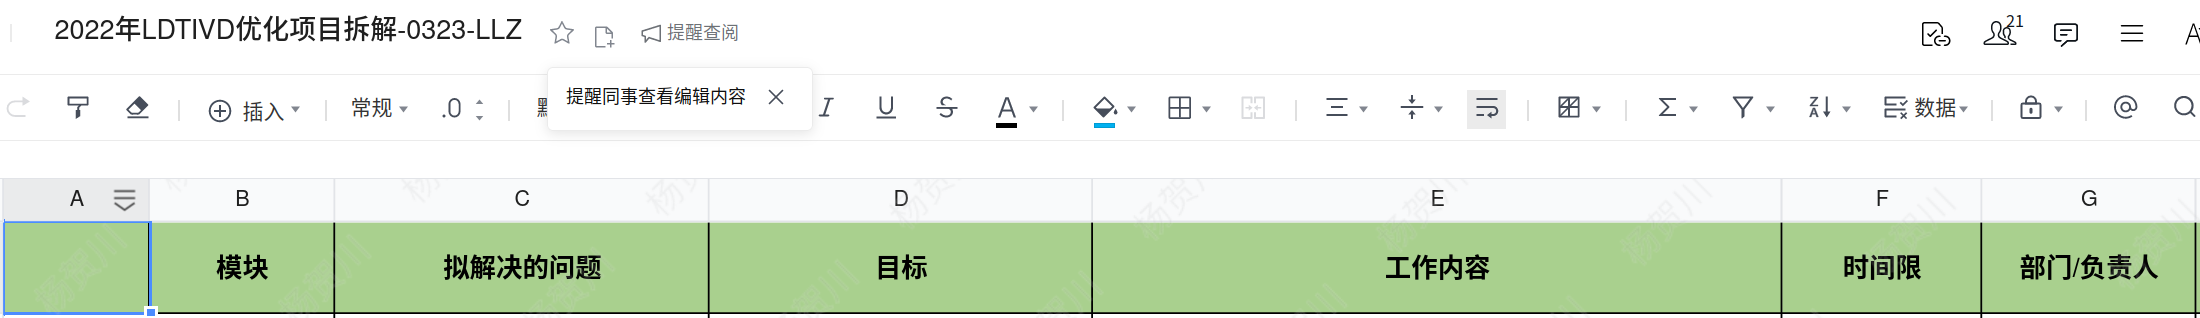

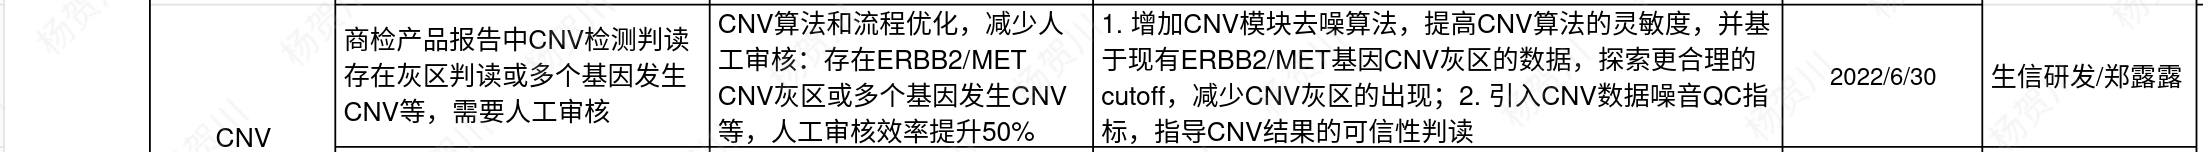

### 1.1 gray zone definition

![gray_zone.png](attachment:gray_zone.png "gray zone definition")
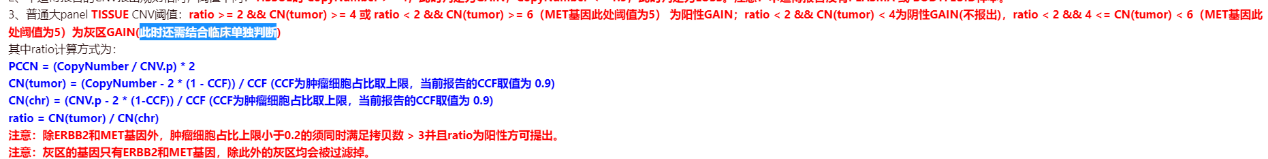

In [1]:
import os
import sys
import pandas as pd
import re

def classify(row):
    if row.gene=='ERBB2':
        if (row.ratio>=2 and row.cn_tumor>=4) or (row.ratio<2 and row.cn_tumor>=6):
            return 'positive_gain'
        elif row.ratio<2 and row.cn_tumor<4:
            return 'negative_gain'
        elif row.ratio<2 and 4 <= row.cn_tumor <6: 
            return 'gray_gain'
        else:
            return 'ERBB2_others'
    elif row.gene=='MET':
        if (row.ratio>=2 and row.cn_tumor>=4) or (row.ratio<2 and row.cn_tumor>=5):
            return 'positive_gain'
        elif row.ratio<2 and row.cn_tumor<4:
            return 'negative_gain'
        elif row.ratio<2 and 4 <= row.cn_tumor <5: 
            return 'gray_gain'
        else:
            return 'MET_others'
    else:
        return 'gene_others'

**灰区的基因只有ERBB2和MET基因，除此之外的灰区均会被过滤掉。**  
**灰区ERBB2和MET基因需结合临床资料判断:**
<code style="background:yellow;color:black"> 指的是，看医院是否有IHC的结果，或者是否用过靶向药物，因为这两个都属于继发耐药变异。</code>

### 1.2 get CCF (cancer cell fraction) information

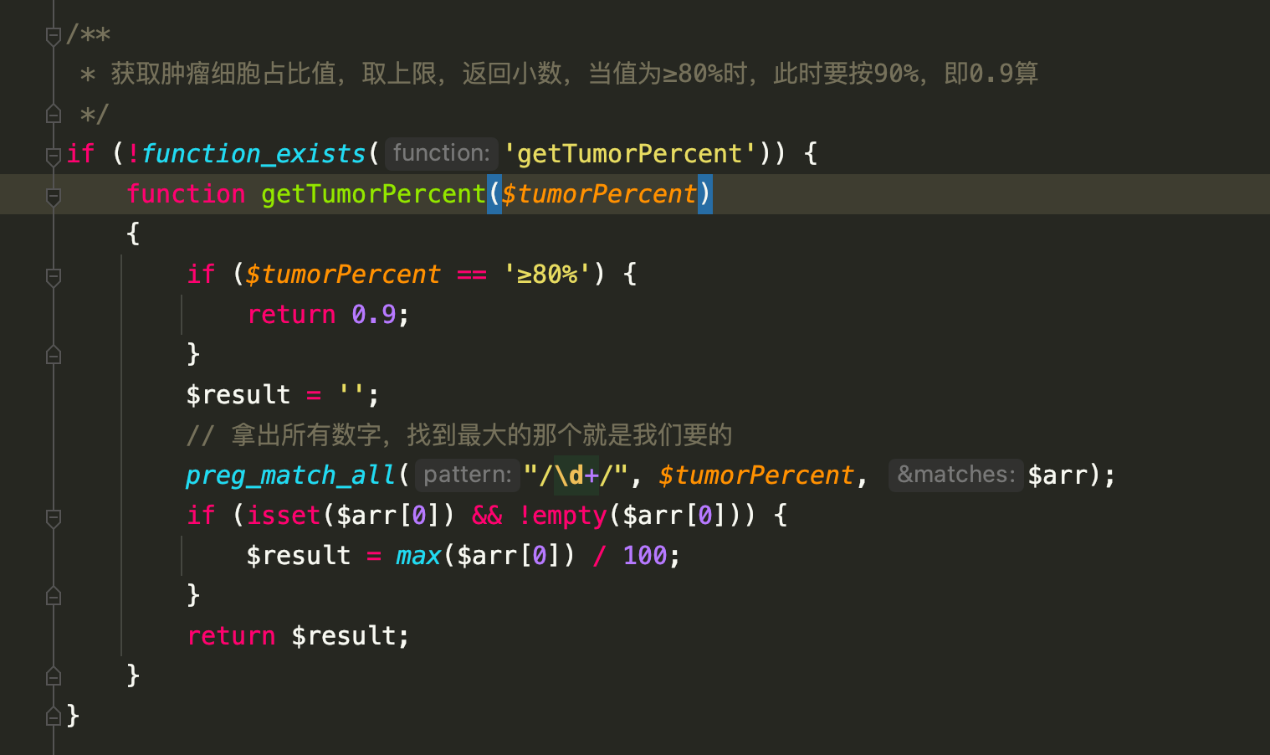

In [2]:
def tumor_cell_percent2ccf(tumorPercent):
    if tumorPercent=='≥80%':
        return 0.9 
    else:
        return max(map(int,re.findall('\d+',tumorPercent)))/100

## 2. materials

Dongfeng helped us extracted ERBB2/MET CNV results from historical records. The time range of the dataset is from 2019-12-30 to 2022-3-14. We focused on the tissue samples with CCF inforamtion available. 

In [3]:
pd.options.mode.chained_assignment = None

#read original table from Dai Dongfeng
data=pd.read_csv('from_dongfeng.csv',
    header=0,na_values='-',
    names=["report_number","sample_id","description","alias_name","sample_attribute",
           "gene","display_mutation","frequency","pccn","ccf","tumor_cell_percent","panel_name","selected"])

#the frequency column in the table is copy_number
data=data.rename(columns={'frequency':'copy_number'})

#let's just focus on tissue samples
data=data.loc[data.sample_attribute=='TISSUE',]

#ccf information is required
with_ccf=data.loc[~(pd.isnull(data.ccf) & pd.isnull(data.tumor_cell_percent)),]
with_ccf['used_ccf']=with_ccf.apply(lambda row: tumor_cell_percent2ccf(row.tumor_cell_percent) if not pd.isnull(row.tumor_cell_percent) else row.ccf, axis=1)

In [4]:
#some records are with different report_number or some other meta information
#but their reporting values associated with CNVs are all the same
with_ccf.drop_duplicates(['sample_id','gene']).shape

(1509, 14)

In [5]:
a=list(with_ccf.columns)
a.remove('report_number')
a.remove('description')
a.remove('alias_name')
a.remove('sample_attribute')
with_ccf.drop_duplicates(a).shape

(1509, 14)

In [6]:
#So, let's remove duplicates on sample_id and gene
with_ccf=with_ccf.drop_duplicates(['sample_id','gene'])

### 2.1 calculate cn_tumor and ratio 
![gray_zone.png](attachment:gray_zone.png "gray zone definition")
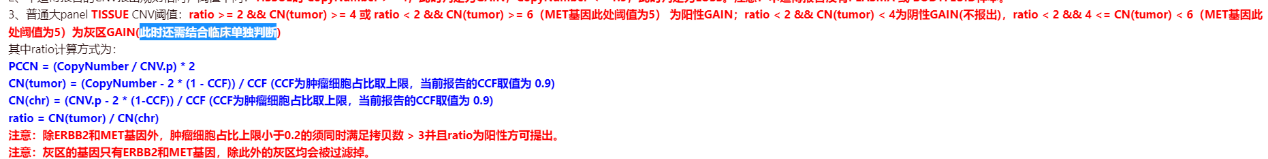

In [7]:
#compute cn_tumor and ratio, which are used in classifying
with_ccf=with_ccf.assign(cn_tumor=lambda dataframe: (dataframe.copy_number-2*(1-dataframe.used_ccf))/dataframe.used_ccf,
                         cnv_p   =lambda dataframe: dataframe.copy_number/(dataframe.pccn/2),
                         cn_chr  =lambda dataframe: (dataframe.cnv_p-2*(1-dataframe.used_ccf))/dataframe.used_ccf,
                         ratio   =lambda dataframe: dataframe.cn_tumor/dataframe.cn_chr)

#let's set the ndigit (e.g. 4), otherwise some cn_number=~4.0 but test(cn_number>=4.0)==False
with_ccf.cn_tumor=with_ccf.cn_tumor.apply(lambda x: round(x,4))
with_ccf.ratio=with_ccf.ratio.apply(lambda x: round(x,4))
with_ccf['results']=with_ccf.apply(lambda row: classify(row), axis=1)

In [8]:
#save results
with_ccf.to_csv('from_dongfeng.csv.annot',index=False,float_format='%.4f')

In [9]:
print(f'There are {with_ccf.shape[0]} tissue records with ccf in the original table!')
print('And the classify results is:')
pd.DataFrame(with_ccf.groupby(by=['results']).size())

There are 1509 tissue records with ccf in the original table!
And the classify results is:


,0
results,
gray_gain,471
negative_gain,4
positive_gain,1034


**I do not know why. But even in positive/negative gain group, the selected results are not all 1 or 0!**

In [10]:
#this is just for the original tissue data
pd.DataFrame(with_ccf.groupby(by=['results','selected']).size())

0
results       selected     
gray_gain     0         412
              1          59
negative_gain 0           2
              1           2
positive_gain 0          58
              1         976

## 3. We recalculate the copy_number and PCCN for those samples using ctCNV_svd.py

**2022年2月8号（v2.14.3)，panel15换了新探针，换了新的baseline，这个情况要注意。**

In [11]:
#read svd data
#I rename the columns in svd data. In this way, we can use the same code to compute cn_tumor/cn_chr/ratio,
#and apply the classify function easily on svd data.
svd_data1=pd.read_csv('before220208.svd_cnv.csv',header=0,na_values='-',
                     names=['sample_id','gene','copy_number','pccn','mapd_svd','mapd'])
svd_data2=pd.read_csv('after220208.svd_cnv.csv',header=0,na_values='-',
                     names=['sample_id','gene','copy_number','pccn','mapd_svd','mapd'])
svd_data=pd.concat([svd_data1,svd_data2])
svd_data.shape

(2420, 6)

In [12]:
#there is no duplicates in svd_data
svd_data=svd_data.drop_duplicates(['sample_id','gene'])
svd_data.shape

(2420, 6)

In [13]:
#add used_ccf to svd_data, then we can cassify svd_data using the function classify
svd_data=svd_data.merge(with_ccf.loc[:,['sample_id','gene','used_ccf']],on=['sample_id','gene'],how='inner').drop_duplicates()
svd_data.copy_number=svd_data.copy_number.apply(lambda x: round(x,2))
svd_data.pccn=svd_data.pccn.apply(lambda x: round(x,2))
svd_data.shape

(1463, 7)

In [14]:
svd_data.head()

,sample_id,gene,copy_number,pccn,mapd_svd,mapd,used_ccf
0,R-210831-505410-FFPE-515110-NGS_E210902-080-DN...,ERBB2,3.62,3.17,0.0698,0.0786,0.4
1,R-210829-529897-STF-989950-NGS_E210901-555-DNA...,ERBB2,44.96,34.89,0.1358,0.1358,0.9
2,R-210831-519851-FFPE-495648-NGS_E210902-075-DN...,MET,4.06,2.84,0.0947,0.0937,0.9
3,R-200703-561019-FFPE-491015-NGS_E20070901-15-D...,MET,4.21,2.21,0.1124,0.1283,0.9
4,R-200706-565456-FFPE-979810-NGS_E20070901-19-D...,MET,3.88,2.16,0.0723,0.0839,0.8


In [15]:

#svd_data: compute cn_tumor and ratio for classifying
svd_data=svd_data.assign(cn_tumor=lambda dataframe: (dataframe.copy_number-2*(1-dataframe.used_ccf))/dataframe.used_ccf,
                         cnv_p   =lambda dataframe: dataframe.copy_number/(dataframe.pccn/2),
                         cn_chr  =lambda dataframe: (dataframe.cnv_p-2*(1-dataframe.used_ccf))/dataframe.used_ccf,
                         ratio   =lambda dataframe: dataframe.cn_tumor/dataframe.cn_chr)
svd_data.cn_tumor=svd_data.cn_tumor.apply(lambda x: round(x,4))
svd_data.ratio=svd_data.ratio.apply(lambda x: round(x,4))
svd_data['results']=svd_data.apply(lambda row: classify(row), axis=1)

In [16]:
#combine original data with the svd data
merged_data=with_ccf.merge(svd_data,on=['sample_id','gene'],how='inner',suffixes=[None,'_svd'])

In [17]:
merged_data.head()

,report_number,sample_id,description,alias_name,sample_attribute,gene,display_mutation,copy_number,pccn,ccf,...,copy_number_svd,pccn_svd,mapd_svd,mapd,used_ccf_svd,cn_tumor_svd,cnv_p_svd,cn_chr_svd,ratio_svd,results_svd
0,P204848-1,R-191230-529810-STF-505798-NGS_E20010211-0-DNA...,百适博plus基因检测报告,手术组织（福尔马林）,TISSUE,ERBB2,拷贝数增加,12.18,12.25,NaN,...,11.38,11.96,0.1139,0.1490,0.3,33.2667,1.903010,1.676700,19.8406,positive_gain
1,P204870-1,R-191230-481005-PCTF-999750-NGS_E20010206-4-DN...,百适博plus基因检测报告,穿刺组织（福尔马林）,TISSUE,ERBB2,拷贝数增加,8.90,8.66,NaN,...,8.42,8.12,0.0695,0.0986,0.4,18.0500,2.073892,2.184729,8.2619,positive_gain
2,P205011-1,R-200101-555798-FFPE-545297-NGS_E20010208-15-D...,百适博plus基因检测报告,石蜡切片,TISSUE,ERBB2,拷贝数增加,13.79,12.19,NaN,...,16.93,13.37,0.1589,0.1565,0.5,31.8600,2.532536,3.065071,10.3945,positive_gain
3,P204904-1,R-191231-579755-FFPE-535754-NGS_E20010208-21-D...,百适博plus基因检测报告,石蜡切片,TISSUE,ERBB2,拷贝数增加,4.07,3.86,NaN,...,4.94,4.58,0.0993,0.1186,0.5,7.8800,2.157205,2.314410,3.4048,positive_gain
4,P204984-1,R-191231-971015-FFPE-101989-NGS_E20010409-10-D...,百适博plus基因检测报告,石蜡切片,TISSUE,ERBB2,拷贝数增加,3.95,3.51,NaN,...,5.78,4.87,0.0852,0.1275,0.9,6.2000,2.373717,2.415241,2.5670,positive_gain


In [18]:
#check the original classify results in merged data
pd.DataFrame(merged_data.groupby(by=['results','selected']).size())

0
results       selected     
gray_gain     0         404
              1          57
negative_gain 0           2
              1           2
positive_gain 0          56
              1         942

In [19]:
#save results
merged_data.to_csv('tissue_with_ccf_merged_svd.csv',index=False,float_format='%.4f')

## 4. compare original and svd-denoised data

In [20]:
diff_data=merged_data.loc[merged_data.results != merged_data.results_svd,['sample_id','used_ccf','cn_tumor','cn_chr','copy_number','pccn','ratio','results','cn_tumor_svd','cn_chr_svd','copy_number_svd','pccn_svd','ratio_svd','results_svd','selected']]
diff_data.head()

,sample_id,used_ccf,cn_tumor,cn_chr,copy_number,pccn,ratio,results,cn_tumor_svd,cn_chr_svd,copy_number_svd,pccn_svd,ratio_svd,results_svd,selected
4,R-191231-971015-FFPE-101989-NGS_E20010409-10-D...,0.9,4.1667,2.278569,3.95,3.51,1.8286,gray_gain,6.2000,2.415241,5.78,4.87,2.5670,positive_gain,0
6,R-200103-100499-FFPE-505349-NGS_E20010409-12-D...,0.2,6.3000,5.883495,2.86,2.06,1.0708,positive_gain,5.8500,5.781095,2.77,2.01,1.0119,gray_gain,0
17,R-200115-531025-FFPE-989899-NGS_E20012203-1-DN...,0.6,4.1333,2.516432,3.28,2.84,1.6425,gray_gain,3.8167,2.583016,3.09,2.63,1.4776,negative_gain,1
23,R-200312-525457-FFPE-509948-NGS_E20031401-13-D...,0.3,4.0667,2.491803,2.62,2.44,1.6320,gray_gain,3.6667,2.874811,2.50,2.21,1.2754,negative_gain,1
54,R-200328-101561-PCTF-515448-NGS_E20040304-8-DN...,0.1,4.1000,5.141361,2.21,1.91,0.7975,gray_gain,3.9000,2.563380,2.19,2.13,1.5214,negative_gain,0


In [21]:
merged_data.loc[merged_data.results_svd.str.endswith('other'),]

,report_number,sample_id,description,alias_name,sample_attribute,gene,display_mutation,copy_number,pccn,ccf,...,copy_number_svd,pccn_svd,mapd_svd,mapd,used_ccf_svd,cn_tumor_svd,cnv_p_svd,cn_chr_svd,ratio_svd,results_svd


Text(0, 0.5, 'svd copy number')

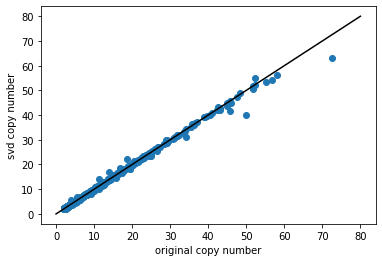

In [22]:
import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.scatter(merged_data['copy_number'],
           merged_data['copy_number_svd'])
##obtain m (slope) and b(intercept) of linear regression line
#m, b = np.polyfit(merged_data['copy_number'], merged_data['copy_number_svd'], 1)
#plt.plot(merged_data['copy_number'],m*merged_data['copy_number']+b,color='red')
#print(m)
ax.plot([0,80],[0,80],color='black')
ax.set_xlabel('original copy number')
ax.set_ylabel('svd copy number')

Text(0, 0.5, 'svd pccn')

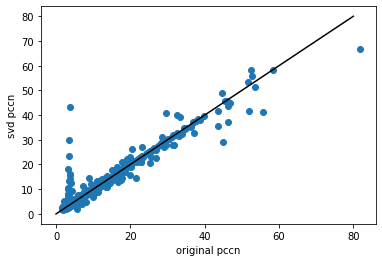

In [23]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.scatter(merged_data['pccn'],
           merged_data['pccn_svd'])
ax.plot([0,80],[0,80],color='black')
ax.set_xlabel('original pccn')
ax.set_ylabel('svd pccn')

In [24]:
pd.DataFrame(diff_data.groupby(by=['results','results_svd','selected']).size())

0
results       results_svd   selected    
gray_gain     ERBB2_others  0          2
              MET_others    0          1
                            1          1
              negative_gain 0         28
                            1          3
              positive_gain 0         28
                            1          7
positive_gain ERBB2_others  0          3
                            1          7
              MET_others    0          1
              gray_gain     0          9
                            1         18
              negative_gain 1          5

The copy number in original/svd results are closely correlated. But the PCCNs are a little different from eahc other.  
If we check the two groups 

**results=='grain_gain' and results_svd=='negative_gain'**

**results=='grain_gain' and results_svd=='positive_gain'** 

We will find the svd-denoising dose not improve the results.

In [25]:
merged_data.loc[(merged_data.results=='positive_gain') & (merged_data.selected==0),:]

,report_number,sample_id,description,alias_name,sample_attribute,gene,display_mutation,copy_number,pccn,ccf,...,copy_number_svd,pccn_svd,mapd_svd,mapd,used_ccf_svd,cn_tumor_svd,cnv_p_svd,cn_chr_svd,ratio_svd,results_svd
6,P205103-1,R-200103-100499-FFPE-505349-NGS_E20010409-12-D...,百适博plus基因检测报告,石蜡切片,TISSUE,ERBB2,拷贝数增加,2.86,2.06,NaN,...,2.77,2.01,0.0751,0.1050,0.2,5.8500,2.756219,5.781095,1.0119,gray_gain
7,P205212-1,R-200104-985710-FFPE-559710-NGS_E20010503-11-D...,百适博plus基因检测报告,石蜡切片（胰腺部位）,TISSUE,MET,拷贝数增加,2.95,2.52,NaN,...,3.25,3.04,0.1110,0.1555,0.2,8.2500,2.138158,2.690789,3.0660,positive_gain
42,P208096-1,R-200325-975510-STF-529755-NGS_E20032805-5-DNA...,百适博plus基因检测报告,手术组织（福尔马林）,TISSUE,MET,拷贝数增加,4.70,2.18,NaN,...,4.70,5.03,0.1320,0.1303,0.7,5.8571,1.868787,1.812553,3.2314,positive_gain
76,P209453-1,R-200417-569957-FFPE-514848-NGS_E20041901-25-D...,百适博plus基因检测报告,石蜡切片,TISSUE,MET,拷贝数增加,3.54,1.90,NaN,...,3.46,2.69,0.0809,0.0901,0.5,4.9200,2.572491,3.144981,1.5644,gray_gain
79,P209444-1,R-200416-485651-FFPE-995254-NGS_E20041901-13-D...,百适博plus基因检测报告,石蜡切片,TISSUE,MET,拷贝数增加,3.07,1.93,NaN,...,3.04,2.14,0.0647,0.0809,0.3,5.4667,2.841121,4.803738,1.1380,positive_gain
88,P208011-1,R-200324-551015-STF-559798-NGS_E20042401-11-DN...,百适博plus基因检测报告,手术组织（福尔马林）,TISSUE,MET,拷贝数增加,2.70,1.89,NaN,...,2.56,2.25,0.1306,0.1504,0.2,4.8000,2.275556,3.377778,1.4211,gray_gain
96,P210232-2,R-200427-101989-FFPE-494852-NGS_E20043005-6-DN...,百适博plus基因检测报告,石蜡切片（19G56584肠）,TISSUE,MET,拷贝数增加,2.75,1.91,NaN,...,2.72,2.66,0.0912,0.0950,0.2,5.6000,2.045113,2.225564,2.5162,positive_gain
118,P210191-1,R-200427-495398-STF-575450-NGS_E20050905-4-DNA...,百适博plus基因检测报告,手术组织（福尔马林）,TISSUE,MET,拷贝数增加,3.44,2.15,NaN,...,3.42,2.57,0.0930,0.0978,0.4,5.5500,2.661479,3.653696,1.5190,positive_gain
131,P211298-1,R-200518-525110-STF-101485-NGS_E20052207-4-DNA...,百适博plus基因检测报告,手术组织（福尔马林）,TISSUE,MET,拷贝数增加,2.92,2.15,NaN,...,2.92,3.00,0.1429,0.1667,0.3,5.0667,1.946667,1.822222,2.7805,positive_gain
132,P211470-1,R-200520-495298-FFPE-975554-NGS_E20052203-1-DN...,百适博plus基因检测报告,石蜡切片,TISSUE,MET,拷贝数增加,2.90,1.91,NaN,...,2.85,2.36,0.0663,0.0744,0.3,4.8333,2.415254,3.384181,1.4282,gray_gain


In [26]:
print(merged_data.loc[merged_data.results=='gray_gain',:].shape)
print(merged_data.shape)

(461, 29)
(1463, 29)


In [27]:
merged_data.loc[merged_data.results=='gray_gain',['ratio','cn_tumor']].describe()

,ratio,cn_tumor
count,461.000000,461.000000
mean,0.696736,4.440011
std,10.870707,0.362385
min,-231.400000,4.000000
25%,1.010300,4.166700
50%,1.213600,4.357100
75%,1.579900,4.633300
max,1.990200,5.800000


In [28]:
merged_data.groupby(by=['used_ccf','results','selected']).size()

used_ccf  results        selected
0.1       gray_gain      0            33
                         1             2
          positive_gain  0            10
                         1            43
0.2       gray_gain      0           105
                         1             3
          positive_gain  0            15
                         1           131
0.3       gray_gain      0            63
                         1             4
          positive_gain  0            10
                         1           114
0.4       gray_gain      0            63
                         1            13
          positive_gain  0             7
                         1           125
0.5       gray_gain      0            34
                         1             6
          positive_gain  0             6
                         1            74
0.6       gray_gain      0            30
                         1             6
          positive_gain  0             2
                       

In [29]:
merged_data.groupby(by=['results_svd','selected']).size()

results_svd    selected
ERBB2_others   0             5
               1             7
MET_others     0             2
               1             1
gray_gain      0           354
               1            64
negative_gain  0            30
               1            10
positive_gain  0            71
               1           919
dtype: int64

In [30]:
diff_data.groupby(by=['results','results_svd','selected']).median()

used_ccf  cn_tumor    cn_chr  \
results       results_svd   selected                                 
gray_gain     ERBB2_others  0             0.15    4.3750 -0.797276   
              MET_others    0             0.10    4.9000  8.627907   
                            1             0.20    4.3000  4.424242   
              negative_gain 0             0.35    4.0500  3.562011   
                            1             0.60    4.0667  2.516432   
              positive_gain 0             0.35    4.8619  3.891215   
                            1             0.70    4.4286  3.038790   
positive_gain ERBB2_others  0             0.20    4.4000  1.145299   
                            1             0.10    4.1500  1.604743   
              MET_others    0             0.10    4.1000  0.340249   
              gray_gain     0             0.30    5.0800  5.455497   
                            1             0.40    4.9875  2.181993   
              negative_gain 1             0.40    4.6375  1.707207   

                                      copy_number   pccn     ratio  \
results       results_svd   selected                                 
gray_gain     ERBB2_others  0               2.340  2.780   0.33295   
              MET_others    0               2.290  1.720   0.56790   
                            1               2.460  1.980   0.97190   
              negative_gain 0               2.755  2.085   1.02155   
                            1               3.280  2.440   1.63200   
              positive_gain 0               2.960  2.280   1.24580   
                            1               3.700  2.790   1.48470   
positive_gain ERBB2_others  0               2.400  2.650   3.78570   
                            1               2.270  2.460   2.84210   
              MET_others    0               2.210  2.410  12.05000   
              gray_gain     0               2.900  1.910   0.93170   
                            1               3.165  3.085   2.09825   
              negative_gain 1               2.910  3.070   2.79210   

                                      cn_tumor_svd  cn_chr_svd  \
results       results_svd   selected                             
gray_gain     ERBB2_others  0              3.95000    1.958333   
              MET_others    0              3.90000    1.909091   
                            1              3.90000    1.834711   
              negative_gain 0              3.90000    2.530747   
                            1              3.81670    2.583016   
              positive_gain 0              4.99285    2.222091   
                            1              4.45710    1.973291   
positive_gain ERBB2_others  0              3.80000    0.905660   
                            1              3.87500    1.155898   
              MET_others    0              3.90000    0.024691   
              gray_gain     0              4.90000    3.377778   
                            1              4.73125    2.488898   
              negative_gain 1              3.87780    2.000000   

                                      copy_number_svd  pccn_svd  ratio_svd  
results       results_svd   selected                                        
gray_gain     ERBB2_others  0                   2.390     2.400    2.01700  
              MET_others    0                   2.190     2.200    2.04290  
                            1                   2.380     2.420    2.12570  
              negative_gain 0                   2.680     2.400    1.37260  
                            1                   3.090     2.630    1.47760  
              positive_gain 0                   2.965     2.795    2.24515  
                            1                   3.720     3.650    2.20160  
positive_gain ERBB2_others  0                   2.360     2.650    4.19580  
                            1                   2.280     2.465    3.46225  
              MET_others    0                   2.190     2.430  157.95000  
              gray_ga

In [31]:
diff_data.selected.apply(str)

4       0
6       0
17      1
23      1
54      0
       ..
1420    0
1421    0
1441    0
1452    0
1453    1
Name: selected, Length: 113, dtype: object

In [32]:
gray_selected=with_ccf.loc[(with_ccf.results=='gray_gain') & (with_ccf.selected==1) & (with_ccf.ratio>0),['ratio','cn_tumor','cn_chr','used_ccf']]
gray_selected.describe()

,ratio,cn_tumor,cn_chr,used_ccf
count,59.000000,59.000000,59.000000,59.000000
mean,1.411424,4.476253,3.343979,0.586441
std,0.334969,0.406504,0.801575,0.254922
min,0.824100,4.022200,2.150817,0.100000
25%,1.123300,4.200000,2.722421,0.400000
50%,1.442800,4.325000,3.038790,0.600000
75%,1.729200,4.686100,3.898162,0.900000
max,1.990200,5.800000,5.005618,0.900000


In [33]:
gray_not_selected=with_ccf.loc[(with_ccf.results=='gray_gain') & (with_ccf.selected==0) & (with_ccf.ratio>0),['ratio','cn_tumor','cn_chr','used_ccf']]
gray_not_selected.describe()

,ratio,cn_tumor,cn_chr,used_ccf
count,402.000000,402.000000,402.000000,402.000000
mean,1.283807,4.422448,3.691475,0.418159
std,0.335347,0.347985,1.041037,0.234853
min,0.567900,4.000000,2.083682,0.100000
25%,1.015550,4.150000,2.873458,0.200000
50%,1.211650,4.350000,3.580958,0.400000
75%,1.555350,4.608325,4.289337,0.600000
max,1.985800,5.800000,8.627907,0.900000


Text(0, 0.5, 'ratio(cn_tumor/cn_chr)')

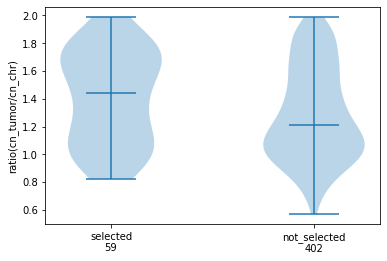

In [34]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.violinplot([gray_selected['ratio'],
               gray_not_selected['ratio']],
              showmedians=True,)
ax.set_xticks([1,2])
ax.set_xticklabels(['selected\n'+str(len(gray_selected)),'not_selected\n'+str(len(gray_not_selected))])
ax.set_ylabel('ratio(cn_tumor/cn_chr)')

Text(0, 0.5, 'cn_tumor')

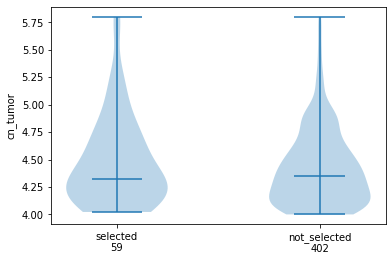

In [35]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.violinplot([gray_selected['cn_tumor'],
               gray_not_selected['cn_tumor']],
              showmedians=True,)
ax.set_xticks([1,2])
ax.set_xticklabels(['selected\n'+str(len(gray_selected)),'not_selected\n'+str(len(gray_not_selected))])
ax.set_ylabel('cn_tumor')

Text(0, 0.5, 'cn_chr')

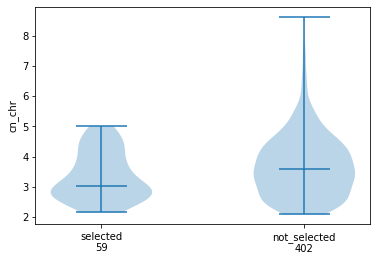

In [36]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.violinplot([gray_selected['cn_chr'],
               gray_not_selected['cn_chr']],
              showmedians=True,)
ax.set_xticks([1,2])
ax.set_xticklabels(['selected\n'+str(len(gray_selected)),'not_selected\n'+str(len(gray_not_selected))])
ax.set_ylabel('cn_chr')

Text(0, 0.5, 'ccf')

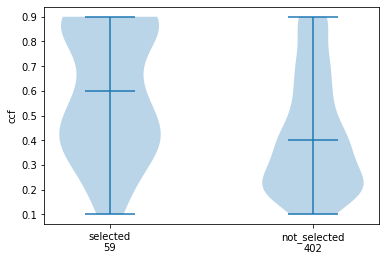

In [37]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
ax.violinplot([gray_selected['used_ccf'],
               gray_not_selected['used_ccf']],
              showmedians=True,)
ax.set_xticks([1,2])
ax.set_xticklabels(['selected\n'+str(len(gray_selected)),'not_selected\n'+str(len(gray_not_selected))])
ax.set_ylabel('ccf')